In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Анализ Изменения Угловой Скорости Вращения Земли (LOD)

В данном анализе мы рассматриваем изменения угловой скорости вращения Земли (LOD - Length of Day) и соответствующее изменение кинетической энергии вращения Земли. Анализ проводится на основе двух наборов данных: с учётом и без учёта приливного воздействия.

### Ключевые Константы и Формулы

- Момент инерции Земли, $I$: $8.0365 \times 10^{37} \, \text{кг} \cdot \text{м}^2$
- Секунд в сутках: $86400 \, \text{с}$
- Референсное значение угловой скорости вращения Земли, $\omega_{\text{ref}}$: $7292115.1467064 \, \text{picorad/s}$
- Перевод пикорадиан в радианы: $1 \, \text{picorad} = 10^{-12} \, \text{радианы}$
- Энергия "Царь-бомбы", $E_{\text{Царь-бомба}}$: $2.45 \times 10^{17} \, \text{Дж}$

### Расчётные Формулы

1. Перевод угловой скорости из пикорадиан/с в радианы/с:
   $$ \omega = (\omega_{\text{ref}} + \omega_{\text{изм}}) \times 10^{-12} $$

2. Расчет кинетической энергии на основе угловой скорости:
   $$ E_{\text{кин}} = \frac{1}{2} I \omega^2 $$

3. Перевод энергии из Джоулей в эквиваленты "Царь-бомбы":
   $$ E_{\text{Царь-бомба}} = \frac{E_{\text{Дж}}}{E_{\text{Царь-бомба}}} $$

In [5]:
# Определение структуры данных
columns = ['year', 'month', 'day', 'x', 'sig_x', 'y', 'sig_y', 'ut1_utc', 'sig_ut1_utc', 'ut1_tai', 'sig_ut1_tai',
           'dX', 'sig_dX', 'dY', 'sig_dY', 'dx_dt', 'sig_dx_dt', 'dy_dt', 'sig_dy_dt', 'lod', 'sig_lod', 'w3', 'sig_w3']
# Загрузка первого файла с данными LOD с учётом приливного воздействия
file_path1 = 'data_from_IERS/EOP_C04_v01.txt'
data1 = pd.read_csv(file_path1, delim_whitespace=True, comment='#', names=columns)

# Загрузка второго файла с данными LOD без учёта приливного воздействия
file_path2 = 'data_from_IERS/EOP_C04_v02.txt'
data2 = pd.read_csv(file_path2, delim_whitespace=True, comment='#', names=columns)

# Объединяем данные из двух файлов
merged_data = data1[['year', 'month', 'day', 'w3', 'sig_w3']].copy()
merged_data['w3_no_tide'] = data2['w3']

# Создаём столбец 'Date' на основе столбцов 'year', 'month' и 'day'
merged_data['Date'] = pd.to_datetime(merged_data[['year', 'month', 'day']])

# Удаляем лишние столбцы
merged_data = merged_data[['Date', 'w3', 'w3_no_tide', 'sig_w3']]

# Копируем данные в новый датасет
lod_df = merged_data.copy()

In [6]:
# Константы и референсные значения
moment_of_inertia = 8.0365e37  # Момент инерции Земли (кг·м²)
seconds_per_day = 86400  # Секунд в сутках
reference_angular_velocity = 72921151.467064  # референсное значение угловой скорости вращения Земли в picorad/s
picorad_to_rad = 1e-12  # 1 пикорадиан = 10^-12 радианов
energy_tsar_bomba_joules = 2.45e17  # Энергия "Царь-бомбы" (Джоули)

# Функции для расчетов
def calculate_angular_velocity(picorad_per_sec):
    # Перевод в радианы в секунду и сложение измеренного значения с референсным
    return (reference_angular_velocity + picorad_per_sec) * picorad_to_rad


def calculate_kinetic_energy(angular_velocity):
    return 0.5 * moment_of_inertia * angular_velocity ** 2


def joules_to_tsar_bomba(joules):
    return joules / energy_tsar_bomba_joules


def watts_to_tsar_bomba_per_day(watts):
    return (watts * seconds_per_day) / energy_tsar_bomba_joules

# Расчеты
lod_df['Angular_Velocity'] = calculate_angular_velocity(lod_df['w3'])
lod_df['Angular_Velocity_no_tide'] = calculate_angular_velocity(lod_df['w3_no_tide'])

lod_df['Kinetic_Energy'] = calculate_kinetic_energy(lod_df['Angular_Velocity'])
lod_df['Kinetic_Energy_no_tide'] = calculate_kinetic_energy(lod_df['Angular_Velocity_no_tide'])

lod_df['Change_in_Kinetic_Energy'] = lod_df['Kinetic_Energy'].diff()
lod_df['Change_in_Kinetic_Energy_no_tide'] = lod_df['Kinetic_Energy_no_tide'].diff()

lod_df['Change_in_Kinetic_Energy_TsarBomba'] = joules_to_tsar_bomba(lod_df['Change_in_Kinetic_Energy'])
lod_df['Change_in_Kinetic_Energy_TsarBomba_no_tide'] = joules_to_tsar_bomba(lod_df['Change_in_Kinetic_Energy_no_tide'])

lod_df['RMS_Change_in_Kinetic_Energy'] = np.sqrt((lod_df['Change_in_Kinetic_Energy'] ** 2).rolling(window=365).mean())
lod_df['RMS_Change_in_Kinetic_Energy_no_tide'] = np.sqrt((lod_df['Change_in_Kinetic_Energy_no_tide'] ** 2).rolling(window=365).mean())

# Пересчитываем оценку RMS в царь-бомбы для до и после вычитания приливов
lod_df['RMS_Change_in_Kinetic_Energy_TsarBomba'] = joules_to_tsar_bomba(lod_df['RMS_Change_in_Kinetic_Energy'])
lod_df['RMS_Change_in_Kinetic_Energy_TsarBomba_no_tide'] = joules_to_tsar_bomba(lod_df['RMS_Change_in_Kinetic_Energy_no_tide'])

RMS_KE = np.sqrt((lod_df['Change_in_Kinetic_Energy'] ** 2).mean())
RMS_KE2 = np.sqrt((lod_df['Change_in_Kinetic_Energy_no_tide'] ** 2).mean())
RMS_KE_CB = joules_to_tsar_bomba(RMS_KE)
RMS_KE2_CB = joules_to_tsar_bomba(RMS_KE2)
RMS_KE_CB, RMS_KE2_CB

(2794.451265127293, 709.1486623078166)

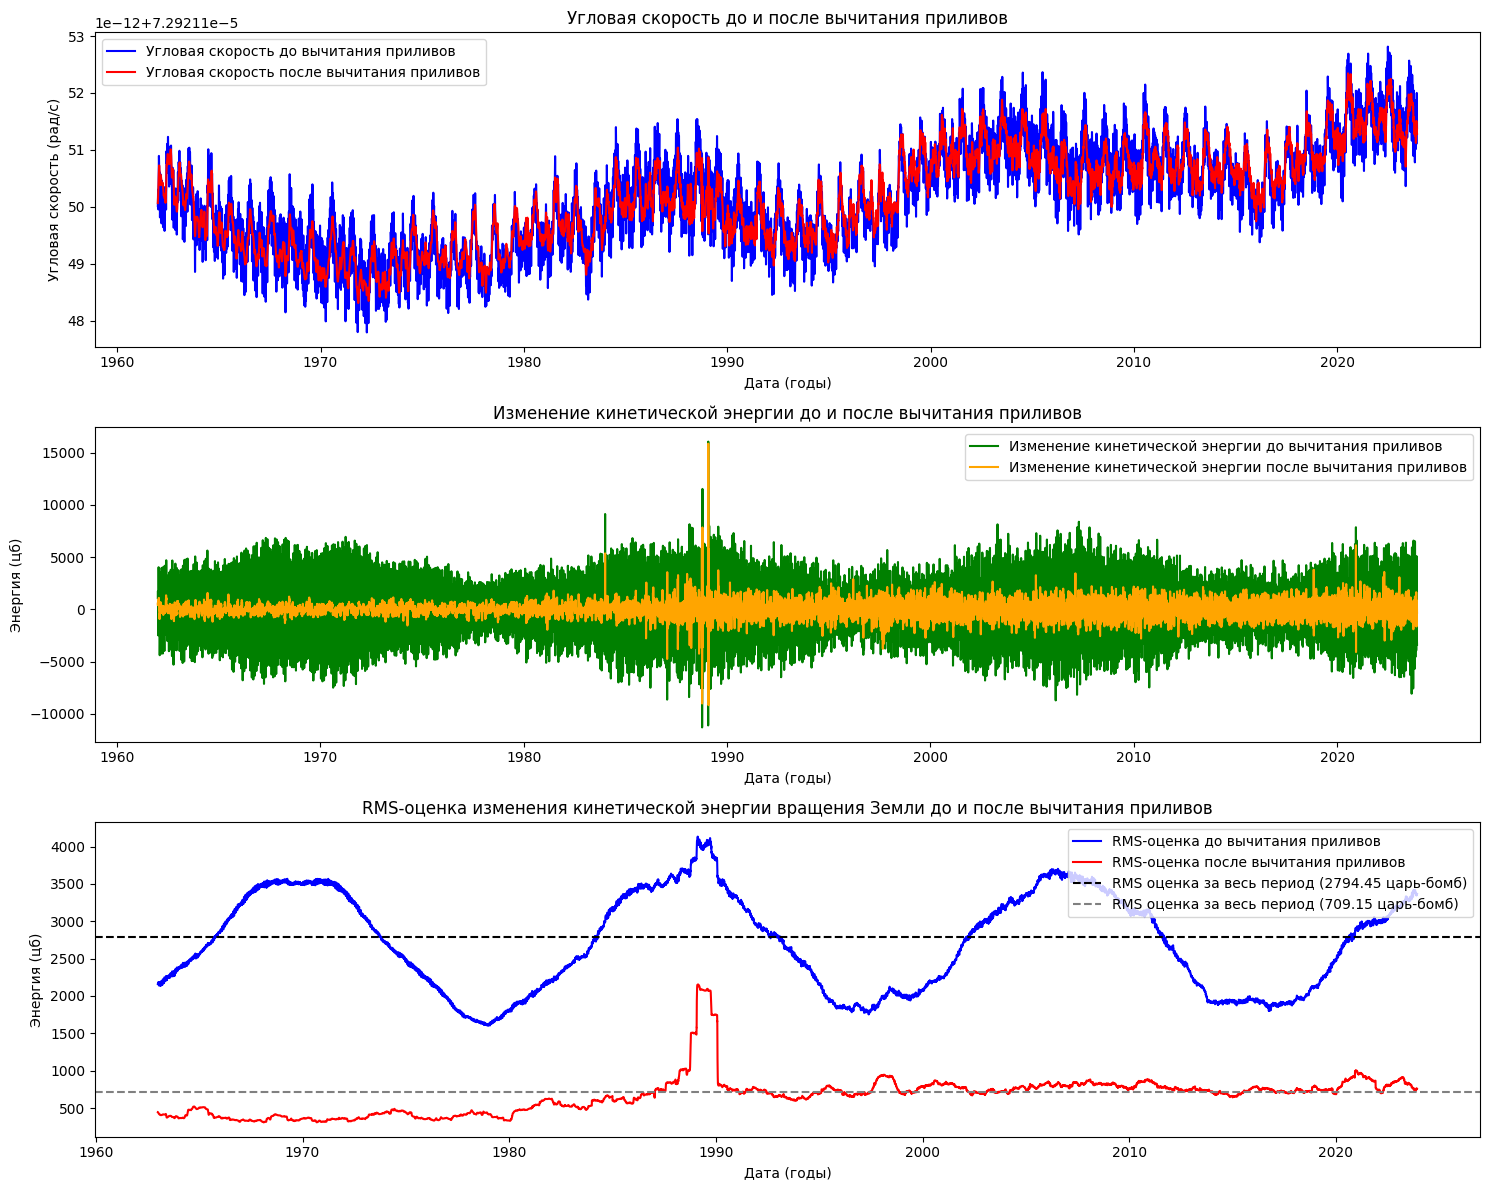

In [7]:
# Графики
plt.figure(figsize=(15, 12))
# Угловая скорость до и после вычитания приливов
plt.subplot(3, 1, 1)
plt.plot(lod_df['Date'], lod_df['Angular_Velocity'], label='Угловая скорость до вычитания приливов', color='blue')
plt.plot(lod_df['Date'], lod_df['Angular_Velocity_no_tide'], label='Угловая скорость после вычитания приливов', color='red')
plt.title('Угловая скорость до и после вычитания приливов')
plt.xlabel('Дата (годы)')
plt.ylabel('Угловая скорость (рад/с)')
plt.legend()

#Изменение кинетической энергии до и после вычитания приливов
plt.subplot(3, 1, 2)
plt.plot(lod_df['Date'], lod_df['Change_in_Kinetic_Energy_TsarBomba'], label='Изменение кинетической энергии до вычитания приливов', color='green')
plt.plot(lod_df['Date'], lod_df['Change_in_Kinetic_Energy_TsarBomba_no_tide'], label='Изменение кинетической энергии после вычитания приливов', color='orange')
plt.title('Изменение кинетической энергии до и после вычитания приливов')
plt.xlabel('Дата (годы)')
plt.ylabel('Энергия (цб)')
plt.legend()

# RMS-оценка изменения энергии в царь-бомбах до и после вычитания приливов
plt.subplot(3, 1, 3)
plt.plot(lod_df['Date'], lod_df['RMS_Change_in_Kinetic_Energy_TsarBomba'], label='RMS-оценка до вычитания приливов', color='blue')
plt.plot(lod_df['Date'], lod_df['RMS_Change_in_Kinetic_Energy_TsarBomba_no_tide'], label='RMS-оценка после вычитания приливов', color='red')
plt.axhline(y=RMS_KE_CB, color='black', linestyle='--', label='RMS оценка за весь период (2794.45 царь-бомб)')
plt.axhline(y=RMS_KE2_CB, color='gray', linestyle='--', label='RMS оценка за весь период (709.15 царь-бомб)')
plt.title('RMS-оценка изменения кинетической энергии вращения Земли до и после вычитания приливов')
plt.xlabel('Дата (годы)')
plt.ylabel('Энергия (цб)')
plt.legend()

plt.tight_layout()

#plt.savefig('RotEnergy_figure.png', dpi=300)
plt.show()
# Закрыть объект figure, чтобы освободить память
plt.close()